In [1]:
# Import necessary libraries
import random
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
!pip install anthropic
from anthropic import Anthropic, HUMAN_PROMPT, AI_PROMPT

# Initialize Anthropic client
anthropic = Anthropic(api_key="YOUR_ANTHROPIC_API_KEY")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.5/865.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00


In [2]:
# Tesla Model Specifications (approximate values)
tesla_models = {
    'Model 3 RWD': {'weight': 1752, 'motor_power': 202, 'battery_capacity': 57.5, 'drag_coefficient': 0.23, 'wear_rate': 1.3},
    'Model 3 Long Range': {'weight': 1844, 'motor_power': 324, 'battery_capacity': 82, 'drag_coefficient': 0.23, 'wear_rate': 1.3},
    'Model 3 Performance': {'weight': 1847, 'motor_power': 413, 'battery_capacity': 82, 'drag_coefficient': 0.23, 'wear_rate': 1.7},
    'Model S': {'weight': 2069, 'motor_power': 500, 'battery_capacity': 100, 'drag_coefficient': 0.208, 'wear_rate': 1.4},
    'Model S Plaid': {'weight': 2162, 'motor_power': 760, 'battery_capacity': 100, 'drag_coefficient': 0.208, 'wear_rate': 1.7},
    'Model X': {'weight': 2352, 'motor_power': 500, 'battery_capacity': 100, 'drag_coefficient': 0.24, 'wear_rate': 1.4},
    'Model X Plaid': {'weight': 2455, 'motor_power': 760, 'battery_capacity': 100, 'drag_coefficient': 0.24, 'wear_rate': 1.7},
    'Model Y RWD': {'weight': 1909, 'motor_power': 220, 'battery_capacity': 60, 'drag_coefficient': 0.23, 'wear_rate': 1.3},
    'Model Y Long Range': {'weight': 2003, 'motor_power': 324, 'battery_capacity': 75, 'drag_coefficient': 0.23, 'wear_rate': 1.3},
    'Model Y Performance': {'weight': 2033, 'motor_power': 384, 'battery_capacity': 75, 'drag_coefficient': 0.23, 'wear_rate': 1.7},
    'Cybertruck Single Motor': {'weight': 2721, 'motor_power': 300, 'battery_capacity': 100, 'drag_coefficient': 0.3, 'wear_rate': 1.4},
    'Cybertruck Dual Motor': {'weight': 2948, 'motor_power': 500, 'battery_capacity': 120, 'drag_coefficient': 0.3, 'wear_rate': 1.4},
    'Cybertruck Tri Motor': {'weight': 3175, 'motor_power': 700, 'battery_capacity': 150, 'drag_coefficient': 0.3, 'wear_rate': 1.7}
}

# Tire specifications (approximate values)
tire_specs = {
    'Model 3 RWD': {'size': '18"', 'tread_wear': 400, 'load_index': 99, 'speed_rating': 'W', 'starting_tread': 8},
    'Model 3 Long Range': {'size': '18"', 'tread_wear': 400, 'load_index': 99, 'speed_rating': 'W', 'starting_tread': 8},
    'Model 3 Performance': {'size': '20"', 'tread_wear': 300, 'load_index': 101, 'speed_rating': 'Y', 'starting_tread': 8},
    'Model S': {'size': '19"', 'tread_wear': 300, 'load_index': 105, 'speed_rating': 'W', 'starting_tread': 8},
    'Model S Plaid': {'size': '21"', 'tread_wear': 280, 'load_index': 107, 'speed_rating': 'Y', 'starting_tread': 8},
    'Model X': {'size': '20"', 'tread_wear': 300, 'load_index': 108, 'speed_rating': 'W', 'starting_tread': 8},
    'Model X Plaid': {'size': '22"', 'tread_wear': 285, 'load_index': 110, 'speed_rating': 'Y', 'starting_tread': 8},
    'Model Y RWD': {'size': '19"', 'tread_wear': 350, 'load_index': 101, 'speed_rating': 'W', 'starting_tread': 8},
    'Model Y Long Range': {'size': '19"', 'tread_wear': 350, 'load_index': 101, 'speed_rating': 'W', 'starting_tread': 8},
    'Model Y Performance': {'size': '21"', 'tread_wear': 300, 'load_index': 103, 'speed_rating': 'Y', 'starting_tread': 8},
    'Cybertruck Single Motor': {'size': '35"', 'tread_wear': 500, 'load_index': 121, 'speed_rating': 'T', 'starting_tread': 10},
    'Cybertruck Dual Motor': {'size': '35"', 'tread_wear': 500, 'load_index': 121, 'speed_rating': 'T', 'starting_tread': 10},
    'Cybertruck Tri Motor': {'size': '35"', 'tread_wear': 500, 'load_index': 121, 'speed_rating': 'T', 'starting_tread': 10}
}

In [3]:
def calculate_wear_factor(vehicle_model, trip_distance, speed, acceleration, temperature, road_condition):
    """Calculate the wear factor for a given trip"""
    model_specs = tesla_models[vehicle_model]
    tire_spec = tire_specs[vehicle_model]

    # Calculate various factors affecting tire wear
    base_wear = (trip_distance / 6500) * (model_specs['wear_rate'] / 32)
    weight_factor = (model_specs['weight'] / 1800) ** 0.5
    speed_factor = (speed / 65) ** 1.5
    power_factor = (model_specs['motor_power'] / 300) ** 0.3
    accel_factor = 1 + abs(acceleration) / 5
    temp_factor = 1 + (temperature - 20) / 100 if temperature > 20 else 1
    road_factors = {'dry': 1, 'wet': 1.2, 'icy': 1.5}
    road_factor = road_factors[road_condition]
    tread_factor = 300 / tire_spec['tread_wear']
    size_factor = float(tire_spec['size'].rstrip('"')) / 18

    # Calculate total wear
    total_wear = base_wear * weight_factor * speed_factor * power_factor * accel_factor * temp_factor * road_factor * tread_factor * size_factor

    return total_wear

In [4]:
def simulate_trip(vehicle_model, trip_distance, speed, acceleration, temperature, road_condition, current_tread):
    """Simulate a single trip and calculate remaining tread"""
    wear = calculate_wear_factor(vehicle_model, trip_distance, speed, acceleration, temperature, road_condition)
    wear *= random.uniform(0.9, 1.1)  # Add some randomness
    remaining_tread = [max(0, current_tread - wear * random.uniform(0.95, 1.05)) for _ in range(4)]
    return remaining_tread

def run_simulation(num_simulations=10000):
    """Run the full simulation for multiple vehicles"""
    results = []
    for _ in range(num_simulations):
        vehicle_model = random.choice(list(tesla_models.keys()))
        starting_tread = tire_specs[vehicle_model]['starting_tread']
        current_tread = starting_tread
        total_distance = 0

        while current_tread > 4:  # Simulate until tread reaches 4/32 inch
            trip_distance = random.uniform(10, 500)
            total_distance += trip_distance
            speed = random.uniform(30, 75)
            acceleration = random.uniform(-3, 3)
            temperature = random.uniform(0, 100)
            road_condition = random.choice(['dry', 'wet', 'icy'])

            remaining_tread_fl, remaining_tread_fr, remaining_tread_rl, remaining_tread_rr = simulate_trip(
                vehicle_model, trip_distance, speed, acceleration, temperature, road_condition, current_tread)

            current_tread = min(remaining_tread_fl, remaining_tread_fr, remaining_tread_rl, remaining_tread_rr)

        results.append({
            'vehicle_model': vehicle_model,
            'total_distance': total_distance,
            'final_tread_fl': remaining_tread_fl,
            'final_tread_fr': remaining_tread_fr,
            'final_tread_rl': remaining_tread_rl,
            'final_tread_rr': remaining_tread_rr,
        })
    return pd.DataFrame(results)

In [5]:
def plot_model_accuracy(y_test, predictions, model_name, tire_position):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Tread Depth (32nds of an inch)')
    plt.ylabel('Predicted Tread Depth (32nds of an inch)')
    plt.title(f'{model_name} - {tire_position}: Actual vs Predicted')

    plt.subplot(1, 2, 2)
    residuals = y_test - predictions
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.plot([predictions.min(), predictions.max()], [0, 0], 'r--', lw=2)
    plt.xlabel('Predicted Tread Depth (32nds of an inch)')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - {tire_position}: Residuals')

    plt.tight_layout()
    plt.show()

In [6]:
def train_ml_models(results):
    """Train and evaluate machine learning models"""
    # Prepare the features and target
    X = results[['total_distance', 'vehicle_model']]
    X = pd.get_dummies(X, columns=['vehicle_model'])
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)
    X = X.astype(np.float32)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tire_positions = ['fl', 'fr', 'rl', 'rr']

    for tire in tire_positions:
        y = results[f'final_tread_{tire}']
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest
        rf_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        rf_model = RandomForestRegressor(random_state=42)
        rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error')
        rf_grid.fit(X_train, y_train)
        rf_predictions = rf_grid.predict(X_test)
        print(f"Random Forest - {tire.upper()} Tire MSE:", mean_squared_error(y_test, rf_predictions))
        print(f"Random Forest - {tire.upper()} Tire R^2:", r2_score(y_test, rf_predictions))
        plot_model_accuracy(y_test, rf_predictions, "Random Forest", tire.upper())

        # XGBoost
        xgb_model = xgb.XGBRegressor(random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_predictions = xgb_model.predict(X_test)
        print(f"XGBoost - {tire.upper()} Tire MSE:", mean_squared_error(y_test, xgb_predictions))
        print(f"XGBoost - {tire.upper()} Tire R^2:", r2_score(y_test, xgb_predictions))
        plot_model_accuracy(y_test, xgb_predictions, "XGBoost", tire.upper())

        # Ensemble (average of Random Forest and XGBoost)
        ensemble_predictions = (rf_predictions + xgb_predictions) / 2
        print(f"Ensemble - {tire.upper()} Tire MSE:", mean_squared_error(y_test, ensemble_predictions))
        print(f"Ensemble - {tire.upper()} Tire R^2:", r2_score(y_test, ensemble_predictions))
        plot_model_accuracy(y_test, ensemble_predictions, "Ensemble", tire.upper())

        return {
        'rf': rf_grid,
        'xgb': xgb_model,
        'ensemble': lambda x: (rf_grid.predict(x) + xgb_model.predict(x)) / 2
    }

Tesla Tire Wear Prediction Model
Random Forest - FL Tire MSE: 1.1291458178309184e-05
Random Forest - FL Tire R^2: 0.1358175783716984


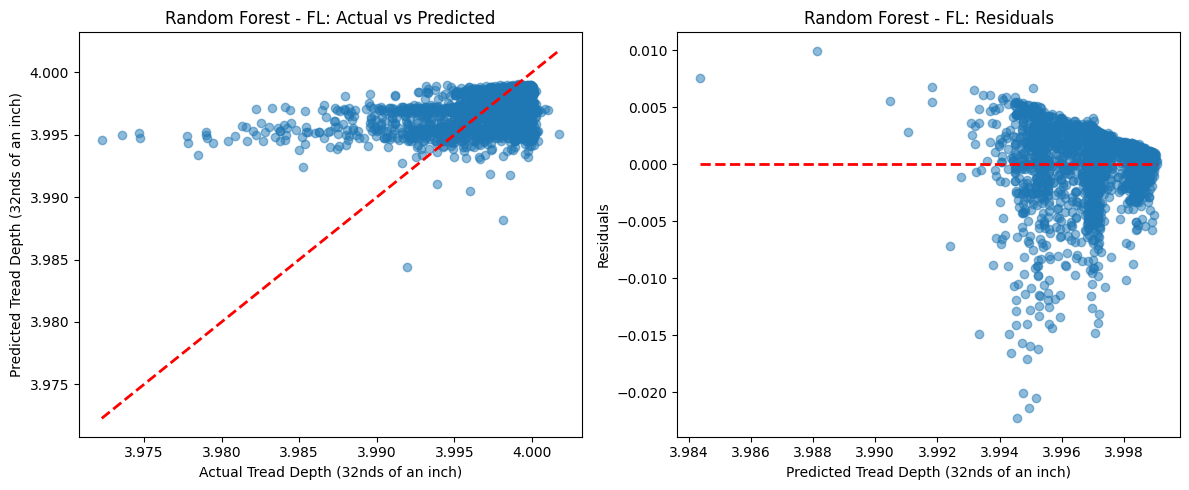

XGBoost - FL Tire MSE: 1.1254846952734482e-05
XGBoost - FL Tire R^2: 0.13861958826947252


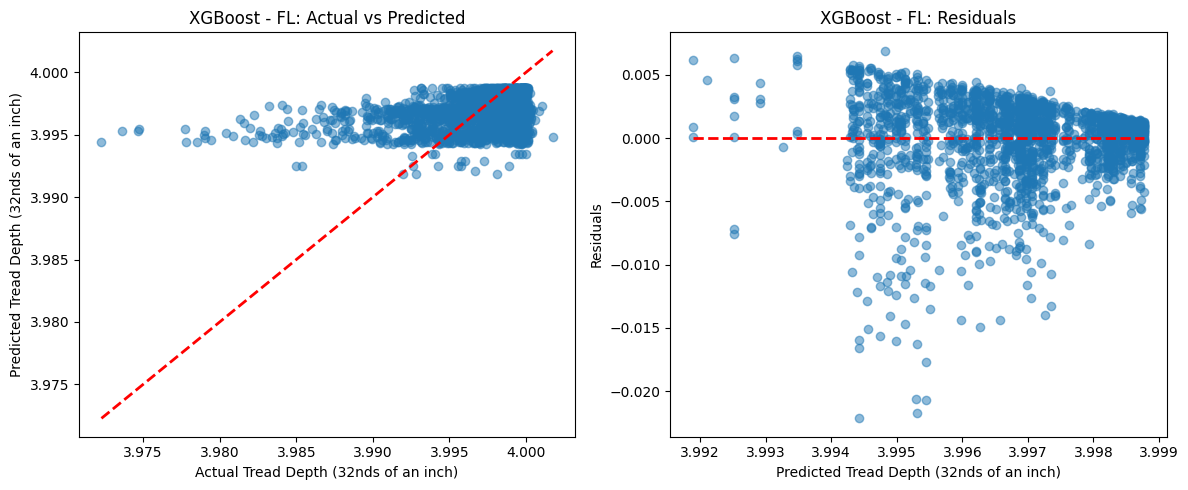

Ensemble - FL Tire MSE: 1.1203595455441386e-05
Ensemble - FL Tire R^2: 0.14254207926606555


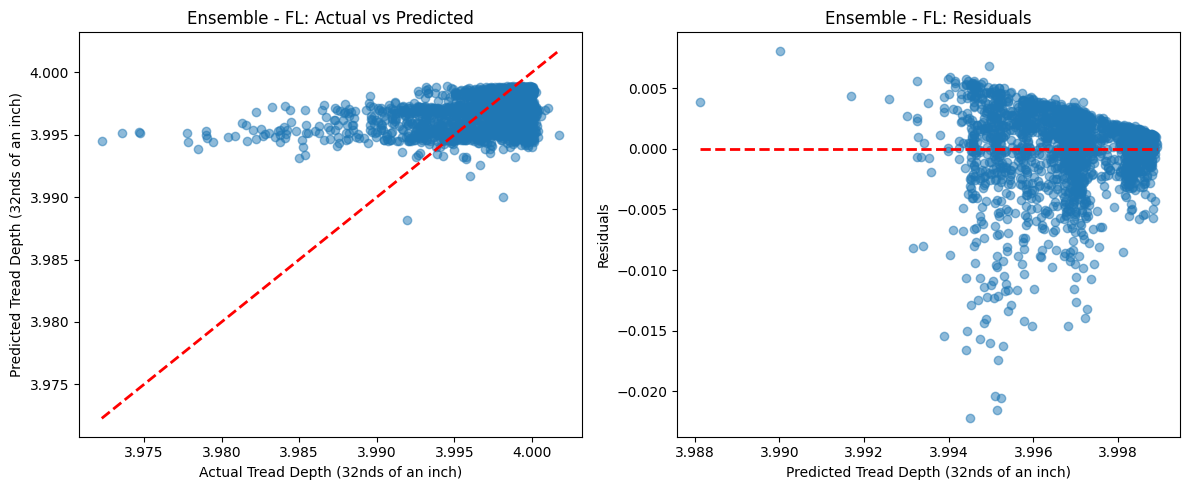

Simulation complete and ML models trained.

What would you like to do?
1. Get tire wear prediction and advice
2. Analyze driving habits
3. Exit


In [ ]:
def predict_wear(models, X):
    """Predict wear using trained models"""
    predictions = {}
    for tire in ['fl', 'fr', 'rl', 'rr']:
        predictions[tire] = models['ensemble'](X)
    return predictions

def tire_wear_assistant(query, vehicle_model, total_distance, models, scaler):
    # Prepare input for prediction
    X = pd.DataFrame({'total_distance': [total_distance], 'vehicle_model': [vehicle_model]})
    X = pd.get_dummies(X, columns=['vehicle_model'])
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)
    X = X.astype(np.float32)
    X_scaled = scaler.transform(X)

    # Get predictions
    predictions = predict_wear(models, X_scaled)

    # Format predictions for Claude
    prediction_text = f"Predictions for {vehicle_model} after {total_distance} miles:\n"
    for tire, wear in predictions.items():
        prediction_text += f"{tire.upper()} tire: {wear[0]:.2f}/32 inch tread remaining\n"

    # Use Claude to interpret and explain the predictions
    prompt = f"{HUMAN_PROMPT} I have a Tesla {vehicle_model} and I've driven it for {total_distance} miles. {query}\n\nHere are the tire wear predictions:\n{prediction_text}\n\nCan you explain these results and give me advice based on this information?{AI_PROMPT}"

    response = anthropic.completions.create(
        prompt=prompt,
        max_tokens_to_sample=300,
        model="claude-v1"
    )

    return response.completion

def analyze_driving_habits(description):
    prompt = f"{HUMAN_PROMPT} Based on this description of driving habits, can you suggest ways to reduce tire wear on a Tesla?\n\nDriving habits: {description}{AI_PROMPT}"

    response = anthropic.completions.create(
        prompt=prompt,
        max_tokens_to_sample=200,
        model="claude-v1"
    )

    return response.completion

def main():
    print("Tesla Tire Wear Prediction Model")
    num_simulations = 10000
    simulation_results = run_simulation(num_simulations)

    # Prepare features for the model
    X = simulation_results[['total_distance', 'vehicle_model']]
    X = pd.get_dummies(X, columns=['vehicle_model'])
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)
    X = X.astype(np.float32)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    models = train_ml_models(simulation_results)
    print("Simulation complete and ML models trained.")

    while True:
        print("\nWhat would you like to do?")
        print("1. Get tire wear prediction and advice")
        print("2. Analyze driving habits")
        print("3. Exit")

        choice = input("Enter your choice (1-3): ")

        if choice == '1':
            vehicle_model = input("Enter your Tesla model (e.g., 'Model 3 Long Range'): ")
            total_distance = float(input("Enter total distance driven (in miles): "))
            query = input("What would you like to know about your tires? ")
            response = tire_wear_assistant(query, vehicle_model, total_distance, models, scaler)
            print("\nAssistant's response:")
            print(response)

        elif choice == '2':
            habits = input("Describe your driving habits: ")
            advice = analyze_driving_habits(habits)
            print("\nDriving habit analysis:")
            print(advice)

        elif choice == '3':
            print("Thank you for using the Tesla Tire Wear Prediction Model. Goodbye!")
            break

        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()